In [ ]:
import pandas as pd

df = pd.read_csv('definitivo-oficial-fase2-limiar50(2).csv')

# df= df[df['repeat_day_origem']<10]

# df = df.loc[df.index.repeat(df['repeat_day_origem'])]

# df = pd.read_csv('definitivo-oficial-fase2-limiar30.csv')


df

,Unnamed: 0,Veículo,grid_origem,grid_destino,dia,contagem
0,197,181,66030,75312,Friday,5
1,198,181,66030,75312,Friday,5
2,199,181,66030,75312,Friday,5
3,200,181,66030,75312,Friday,5
4,201,181,66030,75312,Friday,5
...,...,...,...,...,...,...
2124,3765,597,30422,69926,Wednesday,5
2125,3766,597,30422,69926,Wednesday,5
2126,3767,597,30422,69926,Wednesday,5
2127,3768,597,30422,69926,Wednesday,5


In [ ]:
!pip install pydtmc==8.7.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 96.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 89.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
plotnine 0.14.6 requires matplotlib>=3.8.0, but you have 

**HMM Corrigido**

A saída de streaming foi truncada nas últimas 5000 linhas.
          Erro Viterbi: The "symbols" parameter must contain at least 2 el
          Erro Viterbi: The "symbols" parameter must contain at least 2 el
          Erro Viterbi: The "symbols" parameter must contain at least 2 el
          Erro Viterbi: The "symbols" parameter must contain at least 2 el
          Erro Viterbi: The "symbols" parameter must contain at least 2 el
          Erro Viterbi: The "symbols" parameter must contain at least 2 el
          Erro Viterbi: The "symbols" parameter must contain at least 2 el
        Fold 1: 10 predições, precisão=0.5500
        Processando fold 2: treino=88, teste=10
          Erro Viterbi: The "symbols" parameter must contain at least 2 el
          Erro Viterbi: The "symbols" parameter must contain at least 2 el
          Erro Viterbi: The "symbols" parameter must contain at least 2 el
          Erro Viterbi: The "symbols" parameter must contain at least 2 el
          Erro Viterbi

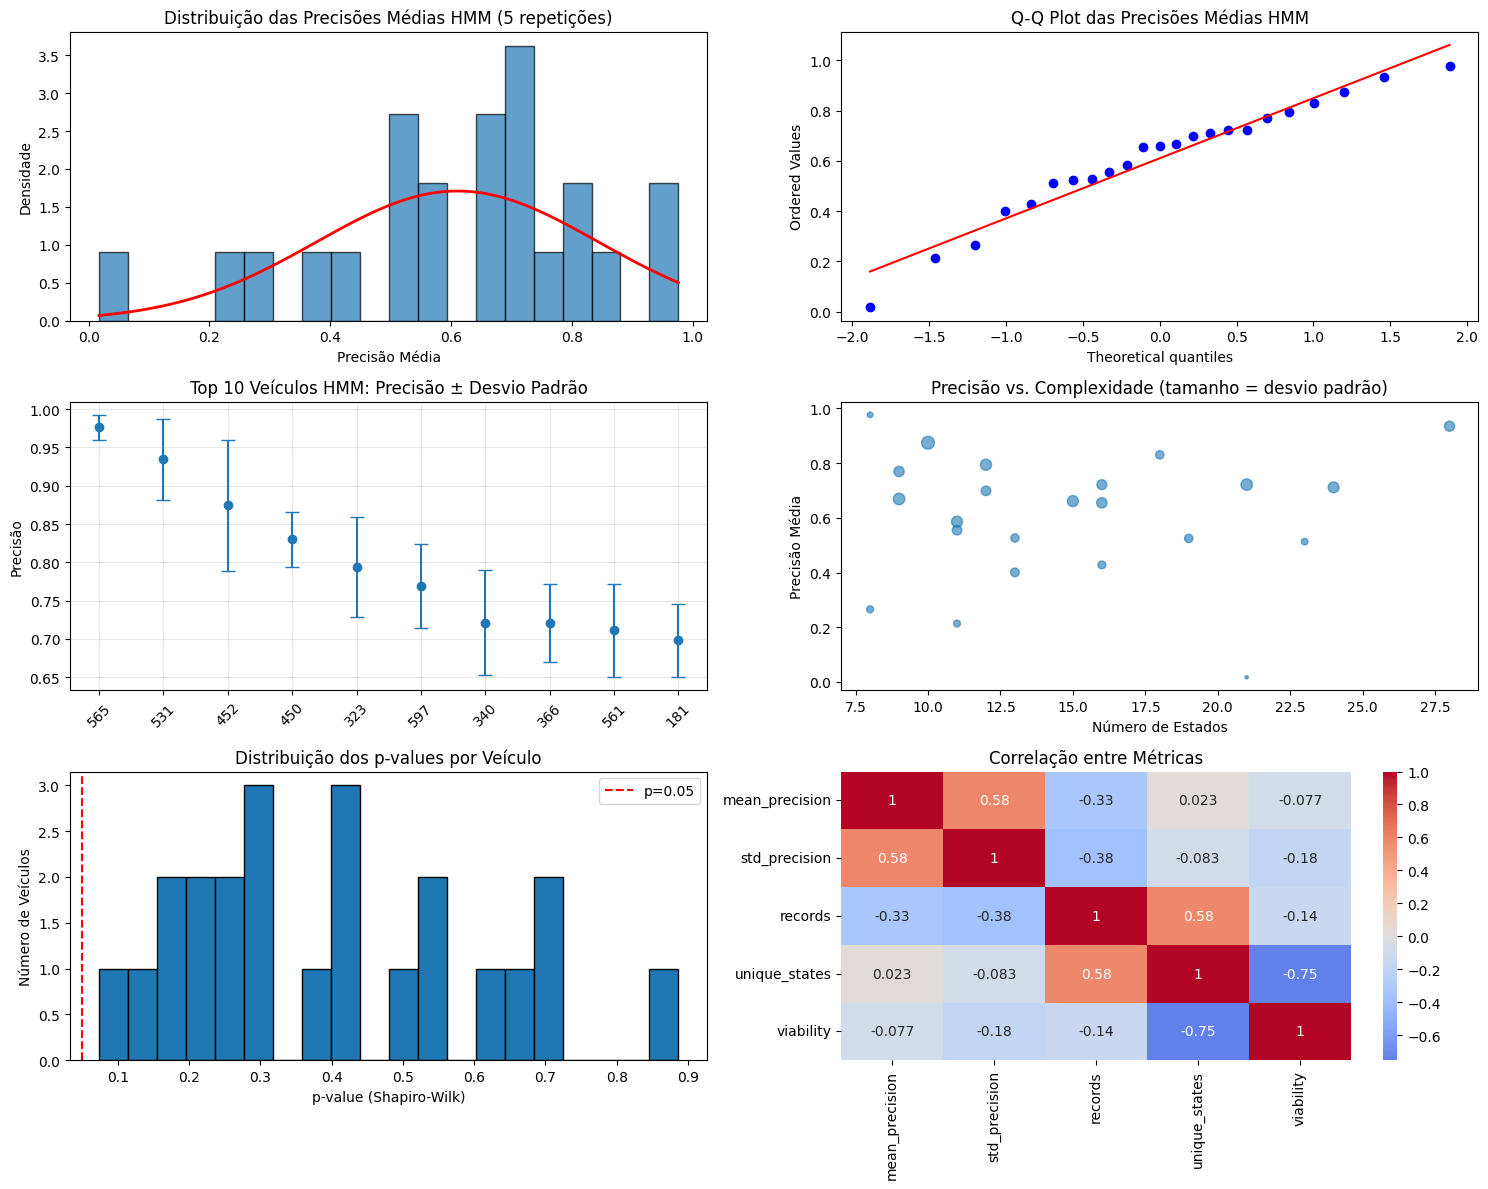

In [ ]:
################### BLOCO 1: IMPORTS E CONFIGURAÇÃO INICIAL ###################
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, norm, probplot
import pydtmc

# Garantindo que todas as strings sejam corretamente interpretadas
df['grid_origem'] = df['grid_origem'].astype(str)
df['grid_destino'] = df['grid_destino'].astype(str)
df['dia'] = df['dia'].astype(str)

# Análise exploratória para HMM
print("=== Análise dos Veículos para HMM com 10 Repetições ===")
vehicle_stats = []

for vehicle_id, group in df.groupby('Veículo'):
    # Estados únicos - EXATAMENTE COMO MARKOV
    states = sorted(list(set(
        group['grid_origem'].tolist() +
        group['grid_destino'].tolist()
    )))

    # Para HMM, número potencial de transições diretas entre estados
    potential_transitions = len(states) * len(states)

    # Estatísticas
    vehicle_stats.append({
        'vehicle_id': vehicle_id,
        'records': len(group),
        'unique_states': len(states),
        'potential_transitions': potential_transitions,
        'viability': len(group) / potential_transitions if potential_transitions > 0 else 0
    })

# Ordenar por viabilidade
vehicle_stats_df = pd.DataFrame(vehicle_stats)
vehicle_stats_df = vehicle_stats_df.sort_values('viability', ascending=False)

print("Top 10 veículos com maior viabilidade para HMM:")
print(vehicle_stats_df.head(10))

# Dicionário global para armazenar resultados
all_results = {}

# Configuração para K-fold e repetições - IDÊNTICA AO MARKOV
n_splits = 10
n_repeats = 10

# Testar diferentes combinações de hiperparâmetros - IDÊNTICA AO MARKOV
alpha_values = [0.001, 0.01, 0.05, 0.1]

# Processar cada veículo separadamente
for vehicle_id, vehicle_data in df.groupby('Veículo'):
    print(f"\nProcessando veículo {vehicle_id} com HMM (5 repetições)...")

    # Verificar se há dados suficientes - IDÊNTICO AO MARKOV
    if len(vehicle_data) < 10:
        print(f"  Pulando: poucos registros ({len(vehicle_data)})")
        continue

    # Estados deste veículo específico - IDÊNTICO AO MARKOV
    vehicle_states = sorted(list(set(
        vehicle_data['grid_origem'].tolist() +
        vehicle_data['grid_destino'].tolist()
    )))

    if len(vehicle_states) < 2:
        print(f"  Pulando: poucos estados únicos ({len(vehicle_states)})")
        continue

    # Criar símbolos observáveis compostos - DIA + GRID ORIGEM
    vehicle_data['simbolo'] = vehicle_data.apply(
        lambda row: f"dia:{row['dia']}_grid:{row['grid_origem']}",
        axis=1
    )
    vehicle_symbols = sorted(vehicle_data['simbolo'].unique())

    # Preparar estruturas para armazenar resultados
    all_repeat_results = []
    all_fold_precisions = []

    # LOOP DE REPETIÇÕES - IDÊNTICO AO MARKOV
    for repeat_idx in range(n_repeats):
        print(f"  Repetição {repeat_idx+1}/{n_repeats}")

        # Usar random_state diferente para cada repetição
        repeat_random_state = 42 + repeat_idx

        # Criar KFold com novo random_state
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=repeat_random_state)

        # Armazenar resultados por configuração de alpha
        alpha_results = {}

        # Testar cada valor de alpha
        for alpha in alpha_values:
            fold_precisions = []

            # Aplicar KFold para este alpha - IDÊNTICO AO MARKOV
            for fold_idx, (train_index, test_index) in enumerate(kf.split(vehicle_data)):
                # Dividir dados - IDÊNTICO AO MARKOV
                vehicle_train = vehicle_data.iloc[train_index]
                vehicle_test = vehicle_data.iloc[test_index]

                # Verificar se temos dados suficientes - IDÊNTICO AO MARKOV
                if len(vehicle_train) < 5 or len(vehicle_test) < 2:
                    continue

                try:
                    print(f"        Processando fold {fold_idx}: treino={len(vehicle_train)}, teste={len(vehicle_test)}")

                    # Etapa 1: Inicializar matrizes HMM
                    # Matriz de transição (estados -> estados)
                    transition_counts = defaultdict(lambda: defaultdict(float))
                    # Matriz de emissão (estados -> observações)
                    emission_counts = defaultdict(lambda: defaultdict(float))

                    # Adicionar pseudocontagem alpha
                    for state1 in vehicle_states:
                        for state2 in vehicle_states:
                            transition_counts[state1][state2] = alpha
                        for symbol in vehicle_symbols:
                            emission_counts[state1][symbol] = alpha

                    # Etapa 2: Contabilizar transições e emissões no treino
                    # IMPORTANTE: Transições são entre estados ocultos consecutivos (grid_destino -> grid_destino)
                    for i in range(len(vehicle_train) - 1):
                        # Estado atual e próximo (ambos são grid_destino)
                        current_state = vehicle_train.iloc[i]['grid_destino']
                        next_state = vehicle_train.iloc[i + 1]['grid_destino']

                        # Transição entre estados ocultos
                        transition_counts[current_state][next_state] += 1

                    # Emissões: cada estado emite uma observação
                    for i in range(len(vehicle_train)):
                        state = vehicle_train.iloc[i]['grid_destino']
                        observation = vehicle_train.iloc[i]['simbolo']  # dia + grid_origem
                        emission_counts[state][observation] += 1

                    # Etapa 3: Criar matrizes normalizadas
                    state_to_idx = {state: i for i, state in enumerate(vehicle_states)}
                    idx_to_state = {i: state for i, state in enumerate(vehicle_states)}

                    # Matriz de transição
                    p_matrix = np.zeros((len(vehicle_states), len(vehicle_states)))
                    for i, state1 in enumerate(vehicle_states):
                        row_sum = sum(transition_counts[state1].values())
                        if row_sum > 0:
                            for j, state2 in enumerate(vehicle_states):
                                p_matrix[i, j] = transition_counts[state1][state2] / row_sum
                        else:
                            p_matrix[i, :] = 1.0 / len(vehicle_states)

                    # Matriz de emissão
                    e_matrix = np.zeros((len(vehicle_states), len(vehicle_symbols)))
                    symbol_to_idx = {symbol: i for i, symbol in enumerate(vehicle_symbols)}

                    for i, state in enumerate(vehicle_states):
                        row_sum = sum(emission_counts[state].values())
                        if row_sum > 0:
                            for j, symbol in enumerate(vehicle_symbols):
                                e_matrix[i, j] = emission_counts[state][symbol] / row_sum
                        else:
                            e_matrix[i, :] = 1.0 / len(vehicle_symbols)

                    # Verificar normalização
                    assert np.allclose(p_matrix.sum(axis=1), 1.0), "Matriz transição não normalizada"
                    assert np.allclose(e_matrix.sum(axis=1), 1.0), "Matriz emissão não normalizada"

                    # Etapa 4: Criar HMM
                    hmm = pydtmc.HiddenMarkovModel(
                        p=p_matrix,
                        e=e_matrix,
                        states=vehicle_states,
                        symbols=vehicle_symbols
                    )

                    # Etapa 5: Avaliar no conjunto de teste COM VITERBI
                    y_true = []
                    y_pred = []

                    for idx in range(len(vehicle_test)):
                        # Observação composta atual
                        observacao_atual = vehicle_test.iloc[idx]['simbolo']
                        estado_real = vehicle_test.iloc[idx]['grid_destino']

                        if observacao_atual in vehicle_symbols and estado_real in vehicle_states:
                            try:
                                # Usar Viterbi com observação composta (dia + grid origem)
                                initial_dist = np.ones(len(vehicle_states)) / len(vehicle_states)

                                predicted_result = hmm.predict(
                                    prediction_type='viterbi',
                                    symbols=[observacao_atual],  # dia + grid origem
                                    initial_status=initial_dist,
                                    output_indices=False
                                )

                                if predicted_result is not None:
                                    log_prob, states_path = predicted_result
                                    estado_predito = states_path[-1]  # grid destino predito
                                else:
                                    # Fallback: estado mais provável dada a observação
                                    obs_idx = symbol_to_idx[observacao_atual]
                                    emission_probs = e_matrix[:, obs_idx]
                                    estado_predito = vehicle_states[np.argmax(emission_probs)]

                            except Exception as e:
                                print(f"          Erro Viterbi: {str(e)[:50]}")
                                # Fallback: usar emissão direta
                                try:
                                    obs_idx = symbol_to_idx[observacao_atual]
                                    emission_probs = e_matrix[:, obs_idx]
                                    estado_predito = vehicle_states[np.argmax(emission_probs)]
                                except:
                                    # Se a observação não existir no treino, usar estado mais comum
                                    estado_predito = vehicle_states[0]

                            y_true.append(estado_real)
                            y_pred.append(estado_predito)

                    # Calcular métricas
                    if len(y_true) > 0:
                        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
                        fold_precisions.append(precision)
                        print(f"        Fold {fold_idx}: {len(y_true)} predições, precisão={precision:.4f}")

                except Exception as e:
                    print(f"        ERRO no fold {fold_idx}: {str(e)[:100]}")
                    continue

            # Armazenar resultados deste alpha se tiver folds válidos - IDÊNTICO AO MARKOV
            if len(fold_precisions) >= 3:
                alpha_results[alpha] = {
                    'fold_precisions': fold_precisions,
                    'mean_precision': np.mean(fold_precisions),
                    'std_precision': np.std(fold_precisions),
                    'n_folds': len(fold_precisions)
                }
                print(f"      Alpha={alpha}: {len(fold_precisions)} folds, "
                      f"Precisão={np.mean(fold_precisions):.4f} ± {np.std(fold_precisions):.4f}")

        # Encontrar melhor configuração desta repetição - IDÊNTICO AO MARKOV
        if alpha_results:
            best_alpha = max(alpha_results.keys(), key=lambda x: alpha_results[x]['mean_precision'])
            best_result = alpha_results[best_alpha]

            # Armazenar as precisões dos folds da melhor configuração
            all_fold_precisions.append(best_result['fold_precisions'])

            all_repeat_results.append({
                'repeat': repeat_idx,
                'best_alpha': best_alpha,
                'mean_precision': best_result['mean_precision'],
                'std_precision': best_result['std_precision'],
                'n_valid_folds': best_result['n_folds'],
                'fold_precisions': best_result['fold_precisions']
            })

            print(f"    Melhor resultado: Alpha={best_alpha}, "
                  f"Precisão={best_result['mean_precision']:.4f} ± {best_result['std_precision']:.4f}, "
                  f"Folds válidos={best_result['n_folds']}")
            print(f"    Precisões por fold: {[f'{p:.4f}' for p in best_result['fold_precisions']]}")

    # Consolidar resultados de todas as repetições - IDÊNTICO AO MARKOV
    if all_repeat_results:
        # Calcular média geral e desvio padrão entre repetições
        all_precisions = [r['mean_precision'] for r in all_repeat_results]

        overall_mean_precision = np.mean(all_precisions)
        overall_std_precision = np.std(all_precisions)

        # Encontrar melhor configuração de parâmetros
        alpha_counts = Counter([r['best_alpha'] for r in all_repeat_results])
        best_alpha = alpha_counts.most_common(1)[0][0]

        # Aplicar teste de Shapiro-Wilk nas precisões das repetições
        if len(all_precisions) >= 3:
            stat, p_value = shapiro(all_precisions)
        else:
            stat, p_value = None, None

        all_results[vehicle_id] = {
            'repeat_results': all_repeat_results,
            'overall_mean_precision': overall_mean_precision,
            'overall_std_precision': overall_std_precision,
            'best_alpha': best_alpha,
            'shapiro_stat': stat,
            'shapiro_p_value': p_value,
            'n_repeats': len(all_repeat_results),
            'all_fold_precisions': all_fold_precisions
        }

        print(f"  Resultado final para veículo {vehicle_id}:")
        print(f"    Precisão: {overall_mean_precision:.4f} ± {overall_std_precision:.4f}")
        if p_value is not None:
            print(f"    Teste Shapiro-Wilk: p-value = {p_value:.4f}")
        print(f"    Melhor alpha: {best_alpha}")

# Análise final dos resultados - IDÊNTICA AO MARKOV
print(f"\n=== RESUMO FINAL HMM COM 5 REPETIÇÕES ===")
print(f"Total de veículos processados: {len(all_results)}")

if all_results:
    # Criar DataFrame de resultados
    results_list = []
    for vehicle_id, data in all_results.items():
        results_list.append({
            'vehicle_id': vehicle_id,
            'mean_precision': data['overall_mean_precision'],
            'std_precision': data['overall_std_precision'],
            'best_alpha': data['best_alpha'],
            'shapiro_p_value': data['shapiro_p_value'],
            'n_repeats': data['n_repeats']
        })

    results_df = pd.DataFrame(results_list)

    # Adicionar estatísticas do veículo
    results_df = results_df.merge(
        vehicle_stats_df[['vehicle_id', 'records', 'unique_states', 'viability']],
        on='vehicle_id',
        how='left'
    )

    # Ordenar por precisão média
    results_df = results_df.sort_values('mean_precision', ascending=False)

    print(f"\nPrecisão média global: {results_df['mean_precision'].mean():.4f}")
    print(f"Desvio padrão médio: {results_df['std_precision'].mean():.4f}")

    print("\nTop 10 veículos com melhor desempenho:")
    pd.set_option('display.float_format', '{:.4f}'.format)
    print(results_df.head(10)[['vehicle_id', 'mean_precision', 'std_precision', 'shapiro_p_value', 'records']])

    # Análise de normalidade global
    print(f"\n📊 Análise de Normalidade por Veículo:")
    normal_vehicles = results_df[results_df['shapiro_p_value'] > 0.05]
    print(f"Veículos com distribuição normal (p > 0.05): {len(normal_vehicles)}/{len(results_df)} ({len(normal_vehicles)/len(results_df)*100:.1f}%)")

    # ANÁLISE SHAPIRO-WILK COMPLETA
    print("\n=== ANÁLISE SHAPIRO-WILK DETALHADA ===")

    # 1. Teste global com TODOS os valores de fold
    all_fold_values = []
    for vehicle_id, data in all_results.items():
        for repeat_precisions in data['all_fold_precisions']:
            all_fold_values.extend(repeat_precisions)

    if len(all_fold_values) >= 3:
        global_stat, global_p = shapiro(all_fold_values)
        print(f"\n📊 TESTE GLOBAL (todos os folds de todos os veículos):")
        print(f"Total de observações: {len(all_fold_values)}")
        print(f"Média global: {np.mean(all_fold_values):.4f}")
        print(f"Desvio padrão: {np.std(all_fold_values):.4f}")
        print(f"Estatística Shapiro-Wilk: {global_stat:.4f}")
        print(f"p-value: {global_p:.4f}")
        print(f"Distribuição {'normal' if global_p > 0.05 else 'NÃO normal'} (α = 0.05)")

    # 2. Teste por veículo com valores de folds agrupados
    print(f"\n📊 TESTE POR VEÍCULO (todos os folds agrupados por veículo):")

    vehicle_shapiro_results = []
    for vehicle_id, data in all_results.items():
        # Agrupar todos os folds de todas as repetições deste veículo
        vehicle_all_folds = []
        for repeat_precisions in data['all_fold_precisions']:
            vehicle_all_folds.extend(repeat_precisions)

        if len(vehicle_all_folds) >= 3:
            v_stat, v_p = shapiro(vehicle_all_folds)
            vehicle_shapiro_results.append({
                'vehicle_id': vehicle_id,
                'n_folds': len(vehicle_all_folds),
                'mean': np.mean(vehicle_all_folds),
                'std': np.std(vehicle_all_folds),
                'shapiro_stat': v_stat,
                'shapiro_p_value': v_p,
                'is_normal': v_p > 0.05
            })

    # Contar normalidade
    vehicle_shapiro_df = pd.DataFrame(vehicle_shapiro_results)
    normal_count = len(vehicle_shapiro_df[vehicle_shapiro_df['is_normal']])

    print(f"Veículos com distribuição normal: {normal_count}/{len(vehicle_shapiro_df)} ({normal_count/len(vehicle_shapiro_df)*100:.1f}%)")

    # Mostrar top 10 veículos
    vehicle_shapiro_df = vehicle_shapiro_df.sort_values('mean', ascending=False)
    print("\nTop 10 veículos (teste com todos os folds):")
    for idx, row in vehicle_shapiro_df.head(10).iterrows():
        print(f"\nVeículo {row['vehicle_id']}:")
        print(f"  N° de folds: {row['n_folds']}")
        print(f"  Média: {row['mean']:.4f} ± {row['std']:.4f}")
        print(f"  p-value: {row['shapiro_p_value']:.4f} {'(normal)' if row['is_normal'] else '(NÃO normal)'}")

    # 3. Visualização estilo imagem para um veículo específico
    def visualize_vehicle_hmm(vehicle_id):
        if vehicle_id not in all_results:
            print(f"\nVeículo {vehicle_id} não encontrado")
            return

        data = all_results[vehicle_id]

        print(f"\n\nVehId: {vehicle_id} - HMM")

        # Médias por repetição
        repeat_means = [r['mean_precision'] for r in data['repeat_results']]
        print(f"{repeat_means}")

        # Detalhes por repetição
        for i, repeat_result in enumerate(data['repeat_results']):
            print(f"\n  random_state = {42 + i}")
            print(f"  Precisões dos folds: {repeat_result['fold_precisions']}")

        # Teste Shapiro-Wilk com todos os folds
        all_vehicle_folds = []
        for repeat_precisions in data['all_fold_precisions']:
            all_vehicle_folds.extend(repeat_precisions)

        if len(all_vehicle_folds) >= 3:
            stat, p_val = shapiro(all_vehicle_folds)
            print(f"\n  Teste Shapiro-Wilk (todos os folds):")
            print(f"  p-value = {p_val:.4f}")
            print(f"  Distribuição {'normal' if p_val > 0.05 else 'NÃO normal'}")

    # Exemplo: visualizar o veículo com melhor desempenho
    best_vehicle = results_df.iloc[0]['vehicle_id']
    visualize_vehicle_hmm(best_vehicle)

    # Visualizações
    plt.figure(figsize=(15, 12))

    # 1. Distribuição das precisões médias
    plt.subplot(3, 2, 1)
    plt.hist(results_df['mean_precision'], bins=20, density=True, alpha=0.7, edgecolor='black')
    x = np.linspace(results_df['mean_precision'].min(), results_df['mean_precision'].max(), 100)
    plt.plot(x, norm.pdf(x, results_df['mean_precision'].mean(), results_df['mean_precision'].std()), 'r-', linewidth=2)
    plt.title('Distribuição das Precisões Médias HMM (5 repetições)')
    plt.xlabel('Precisão Média')
    plt.ylabel('Densidade')

    # 2. Q-Q Plot
    plt.subplot(3, 2, 2)
    if len(results_df) >= 3:
        probplot(results_df['mean_precision'].values, plot=plt)
    plt.title('Q-Q Plot das Precisões Médias HMM')

    # 3. Boxplot: Precisão com barras de erro
    plt.subplot(3, 2, 3)
    top_10 = results_df.head(10)
    plt.errorbar(range(len(top_10)), top_10['mean_precision'],
                yerr=top_10['std_precision'], fmt='o', capsize=5)
    plt.xticks(range(len(top_10)), top_10['vehicle_id'], rotation=45)
    plt.title('Top 10 Veículos HMM: Precisão ± Desvio Padrão')
    plt.ylabel('Precisão')
    plt.grid(True, alpha=0.3)

    # 4. Scatter: Precisão vs. Número de Estados
    plt.subplot(3, 2, 4)
    plt.scatter(results_df['unique_states'], results_df['mean_precision'],
                s=results_df['std_precision']*1000, alpha=0.6)
    plt.xlabel('Número de Estados')
    plt.ylabel('Precisão Média')
    plt.title('Precisão vs. Complexidade (tamanho = desvio padrão)')

    # 5. Distribuição dos p-values do teste Shapiro-Wilk
    plt.subplot(3, 2, 5)
    plt.hist(results_df['shapiro_p_value'].dropna(), bins=20, edgecolor='black')
    plt.axvline(x=0.05, color='red', linestyle='--', label='p=0.05')
    plt.xlabel('p-value (Shapiro-Wilk)')
    plt.ylabel('Número de Veículos')
    plt.title('Distribuição dos p-values por Veículo')
    plt.legend()

    # 6. Heatmap: Correlação entre métricas
    plt.subplot(3, 2, 6)
    correlation_data = results_df[['mean_precision', 'std_precision', 'records',
                                   'unique_states', 'viability']].corr()
    sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlação entre Métricas')

    plt.tight_layout()
    plt.savefig('analise_hmm_5_repeticoes_completa.png', dpi=300)
    print("\nGráficos salvos em 'analise_hmm_5_repeticoes_completa.png'")

    # SALVAR TODOS OS RESULTADOS EM DIFERENTES FORMATOS

    # 1. Resultados resumidos por veículo
    results_df.to_csv('resultados_hmm_5_repeticoes.csv', index=False)
    print("\nResultados salvos em 'resultados_hmm_5_repeticoes.csv'")

    # 2. Resultados detalhados por repetição (formato compacto)
    detailed_results = []
    for vehicle_id, data in all_results.items():
        for repeat_result in data['repeat_results']:
            detailed_results.append({
                'vehicle_id': vehicle_id,
                'repeat': repeat_result['repeat'],
                'mean_precision': repeat_result['mean_precision'],
                'n_valid_folds': repeat_result['n_valid_folds'],
                'best_alpha': repeat_result['best_alpha'],
                'fold_precisions': str(repeat_result['fold_precisions'])
            })

    detailed_df = pd.DataFrame(detailed_results)
    detailed_df.to_csv('resultados_hmm_detalhados_por_repeticaonovo.csv', index=False)
    print("Resultados detalhados salvos em 'resultados_hmm_detalhados_por_repeticao.csv'")

    # 3. NOVO: Resultados com TODOS os valores de fold individuais
    all_folds_records = []
    for vehicle_id, data in all_results.items():
        for repeat_idx, repeat_result in enumerate(data['repeat_results']):
            fold_precisions = repeat_result['fold_precisions']

            # Criar um registro para CADA valor de fold
            for fold_idx, precision in enumerate(fold_precisions):
                all_folds_records.append({
                    'vehicle_id': vehicle_id,
                    'repeat': repeat_idx,
                    'fold': fold_idx,
                    'precision': precision,
                    'best_alpha': repeat_result['best_alpha']
                })

    all_folds_df = pd.DataFrame(all_folds_records)
    all_folds_df.to_csv('resultados_hmm_todos_folds_individuais20.csv', index=False)
    print(f"Todos os {len(all_folds_df)} valores de fold salvos em 'resultados_hmm_todos_folds_individuais20.csv'")

    # 4. Salvar resultados Shapiro-Wilk por veículo
    vehicle_shapiro_df.to_csv('resultados_shapiro_wilk_por_veiculo_hmm.csv', index=False)
    print("Resultados Shapiro-Wilk salvos em 'resultados_shapiro_wilk_por_veiculo_hmm.csv'")

    # Estatísticas finais
    print(f"\n=== ESTATÍSTICAS FINAIS ===")
    print(f"Total de veículos processados: {len(all_results)}")
    print(f"Total de valores de fold individuais: {len(all_folds_df)}")
    print(f"Média de folds por veículo: {len(all_folds_df) / len(all_results):.1f}")
    print(f"Estrutura esperada: {len(all_results)} veículos × 10 repetições × ~10 folds = ~{len(all_results)*5*10} valores")

else:
    print("\n⚠️ Nenhum veículo foi processado com sucesso!")

In [ ]:
markovhmm = pd.read_csv('resultados_hmm_detalhados_por_repeticaonovo.csv')

markovhmm.rename(columns={'mean_precision': 'precision'}, inplace=True)

In [ ]:

from scipy import stats

# Primeiro, calcule as médias por veículo
medias_por_veiculo = markovhmm.groupby('vehicle_id')['precision'].mean()

# Teste de Shapiro-Wilk
statistic, p_value = stats.shapiro(medias_por_veiculo)

print(f"Estatística do teste: {statistic:.4f}")
print(f"P-valor: {p_value:.4f}")

# Interpretação
alpha = 0.05
if p_value > alpha:
    print("Não rejeitamos H0: os dados seguem uma distribuição normal")
else:
    print("Rejeitamos H0: os dados não seguem uma distribuição normal")

Estatística do teste: 0.9557
P-valor: 0.3831
Não rejeitamos H0: os dados seguem uma distribuição normal


In [ ]:
markovhmm.to_csv('markovhmm_por_fold_e_repricao_novo.csv')

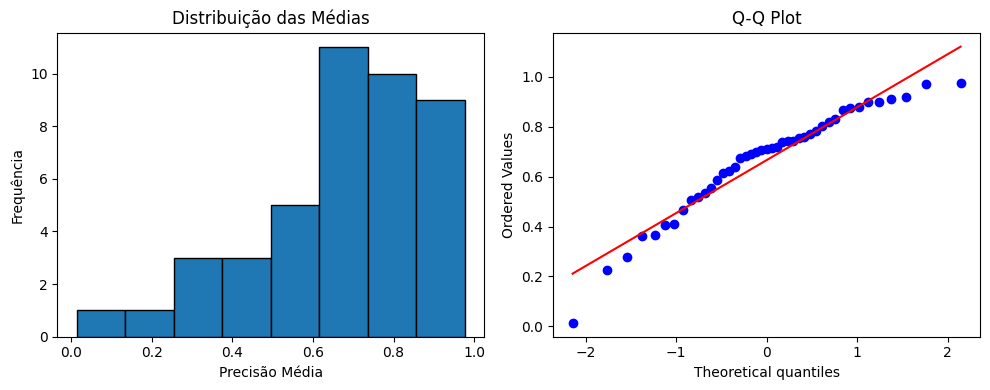

In [ ]:
import matplotlib.pyplot as plt

# Histograma
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(medias_por_veiculo, bins=8, edgecolor='black')
plt.xlabel('Precisão Média')
plt.ylabel('Frequência')
plt.title('Distribuição das Médias')

# Q-Q plot
plt.subplot(1, 2, 2)
stats.probplot(medias_por_veiculo, dist="norm", plot=plt)
plt.title('Q-Q Plot')

plt.tight_layout()
plt.show()

In [ ]:
import pydtmc
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os

def visualizar_grafo_hmm_networkx(vehicle_id, vehicle_data, threshold=0.1):
    """
    Visualiza um modelo HMM para um veículo usando NetworkX para melhor qualidade visual.

    Args:
        vehicle_id: ID do veículo
        vehicle_data: DataFrame com os dados do veículo
        threshold: Limiar de probabilidade mínima para mostrar transições
    """
    # Criar diretório para salvar as imagens
    os.makedirs('grafos_hmm', exist_ok=True)

    # Extrair estados únicos (grids)
    grids = sorted(list(set(
        vehicle_data['grid_origem'].tolist() +
        vehicle_data['grid_destino'].tolist()
    )))

    # Extrair dias únicos
    dias = sorted(vehicle_data['dia'].unique())

    # Limitar para no máximo 8 estados para melhor visualização
    if len(grids) > 8:
        # Contar ocorrências de cada estado
        state_counts = {}
        for state in grids:
            count_origem = sum(vehicle_data['grid_origem'] == state)
            count_destino = sum(vehicle_data['grid_destino'] == state)
            state_counts[state] = count_origem + count_destino

        # Selecionar os estados mais frequentes
        grids = sorted(state_counts.keys(), key=lambda s: state_counts[s], reverse=True)[:8]

        # Filtrar dados
        vehicle_data = vehicle_data[
            (vehicle_data['grid_origem'].isin(grids)) &
            (vehicle_data['grid_destino'].isin(grids))
        ]

    if len(vehicle_data) < 20:
        print(f"Dados insuficientes após filtro para veículo {vehicle_id}")
        return None

    # Criar símbolos observáveis (dias)
    simbolos_observaveis = [f"dia:{dia}" for dia in dias]

    # Garantir pelo menos 2 símbolos
    if len(simbolos_observaveis) == 1:
        simbolos_observaveis.append("placeholder")

    # Criar matriz de transição (entre estados ocultos/grids)
    n_estados = len(grids)
    n_simbolos = len(simbolos_observaveis)
    p_matrix = np.ones((n_estados, n_estados)) * 0.01  # Suavização
    e_matrix = np.ones((n_estados, n_simbolos)) * 0.01  # Suavização

    # Mapear estados e símbolos para índices
    grid_to_idx = {grid: i for i, grid in enumerate(grids)}
    simbolo_to_idx = {simbolo: i for i, simbolo in enumerate(simbolos_observaveis)}

    # Contar transições e emissões
    for i in range(len(vehicle_data)):
        grid_origem = vehicle_data.iloc[i]['grid_origem']
        grid_destino = vehicle_data.iloc[i]['grid_destino']
        dia = vehicle_data.iloc[i]['dia']

        # Verificar se o estado existe nos filtrados
        if grid_origem in grids and grid_destino in grids:
            # Incrementar matriz de transição
            origem_idx = grid_to_idx[grid_origem]
            destino_idx = grid_to_idx[grid_destino]
            p_matrix[origem_idx, destino_idx] += 1

            # Incrementar matriz de emissão - dia emitido pelo estado de destino
            simbolo_dia = f"dia:{dia}"
            if simbolo_dia in simbolo_to_idx:
                e_matrix[destino_idx, simbolo_to_idx[simbolo_dia]] += 1

    # Normalizar matriz de transição
    row_sums = p_matrix.sum(axis=1)
    for i in range(n_estados):
        if row_sums[i] > 0:
            p_matrix[i, :] /= row_sums[i]

    # Normalizar matriz de emissão
    emission_row_sums = e_matrix.sum(axis=1)
    for i in range(n_estados):
        if emission_row_sums[i] > 0:
            e_matrix[i, :] /= emission_row_sums[i]

    # Criar modelo HMM
    hmm = pydtmc.HiddenMarkovModel(
        p=p_matrix,
        e=e_matrix,
        states=grids,
        symbols=simbolos_observaveis
    )

    # Criar grafo usando NetworkX
    G = nx.DiGraph()

    # Adicionar nós para estados ocultos (grids)
    for state in grids:
        freq_origem = sum(vehicle_data['grid_origem'] == state)
        freq_destino = sum(vehicle_data['grid_destino'] == state)
        G.add_node(state, type='state', frequency=freq_origem + freq_destino)

    # Adicionar nós para símbolos observáveis (dias)
    for simbolo in simbolos_observaveis:
        if simbolo != "placeholder":
            G.add_node(simbolo, type='symbol')

    # Adicionar arestas para transições entre estados ocultos
    for i, state1 in enumerate(grids):
        for j, state2 in enumerate(grids):
            prob = p_matrix[i, j]
            if prob > threshold:  # Filtrar transições de baixa probabilidade
                G.add_edge(state1, state2, probability=prob, weight=prob*10, type='transition')

    # Adicionar arestas para emissões (estado -> símbolo)
    for i, state in enumerate(grids):
        for j, simbolo in enumerate(simbolos_observaveis):
            if simbolo != "placeholder":
                prob = e_matrix[i, j]
                if prob > threshold:  # Filtrar emissões de baixa probabilidade
                    G.add_edge(state, simbolo, probability=prob, weight=prob*10, type='emission')

    # Configurar visualização
    plt.figure(figsize=(14, 10))

    # Usar layout específico para HMM (estados e símbolos separados)
    try:
        # Layout em camadas para HMM
        pos = {}

        # Posicionar estados (grids) em um círculo na parte superior
        state_pos = nx.circular_layout([node for node in G.nodes() if G.nodes[node].get('type') == 'state'])
        # Ajustar altura
        for node, position in state_pos.items():
            pos[node] = (position[0], position[1] + 0.3)

        # Posicionar símbolos (dias) em linha na parte inferior
        symbol_nodes = [node for node in G.nodes() if G.nodes[node].get('type') == 'symbol']
        x_increment = 2.0 / (len(symbol_nodes) + 1) if symbol_nodes else 0
        for i, node in enumerate(symbol_nodes):
            pos[node] = (i * x_increment - 1.0, -0.5)
    except:
        # Fallback para layout spring
        pos = nx.spring_layout(G, k=0.9, seed=42)

    # Desenhar nós de estados (grids)
    state_nodes = [node for node in G.nodes() if G.nodes[node].get('type') == 'state']
    state_sizes = [300 + 20 * G.nodes[node].get('frequency', 0) for node in state_nodes]

    nx.draw_networkx_nodes(G, pos,
                          nodelist=state_nodes,
                          node_size=state_sizes,
                          node_color='lightblue',
                          edgecolors='black',
                          linewidths=1,
                          alpha=0.8)

    # Desenhar nós de símbolos (dias)
    symbol_nodes = [node for node in G.nodes() if G.nodes[node].get('type') == 'symbol']
    nx.draw_networkx_nodes(G, pos,
                          nodelist=symbol_nodes,
                          node_size=700,
                          node_color='lightgreen',
                          node_shape='h',  # hexágono para símbolos
                          edgecolors='black',
                          linewidths=1,
                          alpha=0.8)

    # Separar arestas por tipo
    transition_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'transition']
    emission_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('type') == 'emission']

    # Configurar larguras com base nas probabilidades
    transition_widths = [G[u][v]['weight'] for u, v in transition_edges]
    emission_widths = [G[u][v]['weight'] for u, v in emission_edges]

    # Desenhar arestas de transição
    nx.draw_networkx_edges(G, pos,
                          edgelist=transition_edges,
                          width=transition_widths,
                          edge_color='blue',
                          connectionstyle='arc3,rad=0.1',
                          arrowsize=15,
                          alpha=0.7)

    # Desenhar arestas de emissão
    nx.draw_networkx_edges(G, pos,
                          edgelist=emission_edges,
                          width=emission_widths,
                          edge_color='green',
                          style='dashed',
                          connectionstyle='arc3,rad=-0.1',
                          arrowsize=10,
                          alpha=0.7)

    # Adicionar rótulos de probabilidade nas arestas
    edge_labels = {}
    for u, v, data in G.edges(data=True):
        edge_labels[(u, v)] = f"{data['probability']:.2f}"

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    # Adicionar rótulos nos nós
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

    # Adicionar título
    plt.title(f"Modelo HMM - Veículo {vehicle_id}\n({len(grids)} estados, {len(simbolos_observaveis)} símbolos)",
              fontsize=14)

    plt.axis('off')
    plt.tight_layout()

    # Adicionar legenda
    plt.figtext(0.01, 0.01, "⬤ Estados ocultos (grids)", color='lightblue', fontsize=12)
    plt.figtext(0.3, 0.01, "⬢ Símbolos observáveis (dias)", color='lightgreen', fontsize=12)
    plt.figtext(0.6, 0.01, "―→ Transições", color='blue', fontsize=12)
    plt.figtext(0.8, 0.01, "--→ Emissões", color='green', fontsize=12)

    # Salvar figura
    output_file = f"grafos_hmm/hmm_networkx_{vehicle_id}.png"
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.close()

    print(f"Grafo HMM para veículo {vehicle_id} salvo em {output_file}")
    return hmm

# Função para processar apenas o veículo 388
def visualizar_hmm_veiculo_388(df):
    """
    Gera visualização de HMM apenas para o veículo 388.

    Args:
        df: DataFrame com os dados
    """
    vehicle_id = 388

    print(f"Gerando visualização de HMM para o veículo {vehicle_id}...")

    # Filtrar dados
    vehicle_data = df[df['Veículo'] == vehicle_id]

    # Verificar se há dados suficientes
    if len(vehicle_data) < 30:
        print(f"Veículo {vehicle_id} possui poucos registros ({len(vehicle_data)})")
        return

    # Visualizar HMM
    try:
        modelo_hmm = visualizar_grafo_hmm_networkx(vehicle_id, vehicle_data)

        if modelo_hmm:
            # Exibir estatísticas do modelo HMM
            print("\nEstatísticas do modelo HMM para veículo 388:")
            print(f"Número de estados (grids): {len(modelo_hmm.states)}")
            print(f"Número de símbolos (dias): {len(modelo_hmm.symbols)}")

            # Mostrar alguns elementos da matriz de transição
            print("\nMatriz de transição (amostra):")
            transition_matrix = modelo_hmm.p
            n_rows, n_cols = min(5, transition_matrix.shape[0]), min(5, transition_matrix.shape[1])
            for i in range(n_rows):
                row_str = " ".join([f"{transition_matrix[i, j]:.2f}" for j in range(n_cols)])
                print(f"  {modelo_hmm.states[i]}: {row_str} ...")

            # Mostrar alguns elementos da matriz de emissão
            print("\nMatriz de emissão (amostra):")
            emission_matrix = modelo_hmm.e
            n_rows, n_cols = min(5, emission_matrix.shape[0]), min(5, emission_matrix.shape[1])
            for i in range(n_rows):
                row_str = " ".join([f"{emission_matrix[i, j]:.2f}" for j in range(n_cols)])
                print(f"  {modelo_hmm.states[i]}: {row_str} ...")

            print("\nProcessamento do veículo 388 concluído com sucesso.")

    except Exception as e:
        print(f"Erro ao gerar grafo HMM para veículo {vehicle_id}: {e}")

# Executar a função para visualizar HMM apenas para o veículo 388
visualizar_hmm_veiculo_388(df)

Gerando visualização de HMM para o veículo 388...
Grafo HMM para veículo 388 salvo em grafos_hmm/hmm_networkx_388.png

Estatísticas do modelo HMM para veículo 388:
Número de estados (grids): 8
Número de símbolos (dias): 7

Matriz de transição (amostra):
  66449: 0.00 0.00 0.00 0.31 0.15 ...
  66030: 0.00 0.00 0.00 0.00 0.00 ...
  45813: 0.00 1.00 0.00 0.00 0.00 ...
  40098: 0.12 0.12 0.12 0.12 0.12 ...
  75312: 0.99 0.00 0.00 0.00 0.00 ...

Matriz de emissão (amostra):
  66449: 0.00 0.28 0.00 0.00 0.00 ...
  66030: 0.17 0.00 0.00 0.13 0.17 ...
  45813: 0.14 0.14 0.14 0.14 0.14 ...
  40098: 0.14 0.19 0.00 0.14 0.14 ...
  75312: 0.00 0.20 0.00 0.00 0.20 ...

Processamento do veículo 388 concluído com sucesso.
